# <center>JBP031-B-6 Data-structures and algorithms 2023</center>
### <center>Garbage Collection Group Project </center>

#### Graph Class & Test function definition

In [12]:
import os
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import itertools

class Graph:
    """ Graph is composed of Adjacency lists and the target number of bins.
    Two bins should not be placed adjacent to each other."""

    __slots__ = ["n", "m", "k", "adjacency_list"]

    def __init__(self, n, m, k) -> None:
        '''Initialise empty graph

        :param int n: Number of vertices
        :param int m: Number of edges
        :param int k: Target size of independent set
        '''
        self.n = n
        self.m = m
        self.k = k
        self.adjacency_list = [set() for _ in range(n)]

    @classmethod
    def from_file(cls, file_path) -> None:
        '''Loads a graph from a file

        :param str file_path: Path to graph input file
        '''
        with open(file_path, 'r') as f:
            # extract graph parameters
            m, n, k = map(int, f.readline().split())
            # call graph class constructor
            graph = cls(n, m, k)
            # skip whitespaces
            edges = [line for line in f if not line.isspace()]
            for edge in edges:
                # extract vertices connected by edge 
                u, v = map(int, edge.split())
                graph.add_edge(u-1, v-1)

        return graph

    def add_edge(self, u, v) -> None:
        '''Adds an edge between vertex u and vertex v on the adjacency list

        :param int u: Vertex 1 index
        :param int v: Vertex 2 index
        '''
        self.adjacency_list[u].add(v)
        self.adjacency_list[v].add(u)

    
    def draw_graph(self, nodes_to_highlight = None) -> None:
        '''Draws the graph
        
        :param list nodes_to_highlight: List that represents nodes in independent set
        '''
        def adjacency_list_to_matrix(adjacency_list):
            adjacency_matrix = [[False] * self.n for _ in range(self.n)]

            for vertex, neighbors in enumerate(adjacency_list):
                for neighbor in neighbors:
                    adjacency_matrix[vertex][neighbor] = True
                    adjacency_matrix[neighbor][vertex] = True

            return np.array(adjacency_matrix)
        
        # Create graph from adjacency matrix
        G = nx.from_numpy_matrix(adjacency_list_to_matrix(self.adjacency_list))

        pos = nx.spring_layout(G)

        # Draw the graph
        fig, ax = plt.subplots(figsize=(12, 10))

        # Remap nodes from matrix to match input names
        labels = {node: str(node + 1) for node in G.nodes()}

        # Draw vertices with circles
        nx.draw_networkx_nodes(G, pos=pos, node_size=0, ax=ax)
        nodes = nx.draw_networkx_labels(G, pos=pos, labels=labels, font_size=10, font_color='black', ax=ax)

        # Add Circle coloring
        for index, node_patch in nodes.items():
            node_patch.set_bbox(dict(boxstyle="circle,pad=0.3", fc="white", ec="black", lw=2))
            # If there is a given independent set
            if nodes_to_highlight:
                # Set title, if there is at least one True in list
                result_title = "possible" if any(nodes_to_highlight) else "not possible"
                plt.title(result_title)
                # Color nodes
                if nodes_to_highlight[index]:
                    node_patch.set_bbox(dict(boxstyle="circle,pad=0.3", fc="yellow", ec="black", lw=2))

        # Draw edges
        nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color='black')

        # Show plot
        plt.show()

    def validate_and_show_bins(self, algorithm) -> None:
        '''Runs given algorithm and displays result graph
        
        :param function algorithm: Given algorithm that finds the independent set 
        '''
        print(f"Result via '{algorithm.__name__}':")
        result = algorithm(self)
        # Create independent set based on algorithm output
        independent_set = [] if result is None else result
        coloured_vertices = [i in independent_set for i in range(self.n)]

        self.draw_graph(coloured_vertices)

In [13]:
def test_algorithm(algorithm, exclude_long = False) -> None:
    '''Test algorithm against all given cases
    
    :param function algorithm: Algorithm you want to test
    :param boolean exclude_long: Exclude big_4 and big_5 tests
    '''
    directory = "samples/"

    def read_expected(file_path):
        with open(file_path, 'r') as f:
            first_line = f.readline().strip()
        return first_line

    file_paths = sorted([(os.path.join(directory, filename),
                   os.path.join(directory, filename[:-3] + ".out"))
                  for filename in os.listdir(directory)
                  if filename.endswith(".in")], reverse = True)

    if exclude_long:
        file_paths.remove(("samples/big_4.in", "samples/big_4.out"))
        file_paths.remove(("samples/big_6.in", "samples/big_6.out"))

    passed = len(file_paths)
    for in_path, out_path in file_paths:
        print(f"Trying '{in_path.split('/')[-1].split('.')[0]}':", end='')
        graph = Graph.from_file(in_path)

        actual = "possible" if algorithm(graph) is not None else "impossible"
        expected = read_expected(out_path)

        if actual == expected:
            print(" ✅")
        else:
            print(" ❌")
            passed -= 1

    print(f"'{algorithm.__name__}': passed {passed} of {len(file_paths)} test cases!")

        # assert actual == expected, \
        #     f"{algorithm.__name__} returned '{actual}', while '{expected}' was expected"
        # print(" ✅")
    # print(f"\nAll {len(file_paths)} test cases have been passed by the '{algorithm.__name__}' algorithm!")

#### The Algorithm Implementations

In [14]:
def brute_force(graph):
    n = len(graph.adjacency_list)
    # Iterate over all possible vertex combinations of size k
    for combination in itertools.combinations(range(n), graph.k):
        is_independent_set = True

        # Check if any pair of vertices in the combination is connected
        for i, j in itertools.combinations(combination, 2):
            if j in graph.adjacency_list[i]:
                is_independent_set = False
                break

        # If the combination forms an independent set of size k, return it
        if is_independent_set:
            return combination

    # If no independent set of size k is found, return None
    return None

In [15]:
def greedy(graph):
    independent_set = set()
    candidate_vertices = set(range(graph.n))
    
    # repeat until we find independent set of size k or there are no more vertices to consider
    while len(independent_set) < graph.k and len(candidate_vertices) > 0:
        # get the vertex with the smallest degree from candidate_vertices 
        v = min(candidate_vertices, key=lambda x: len(graph.adjacency_list[x]))
        
        # check if vertex is non adjacent to all vertices in independent_set
        if all(w not in graph.adjacency_list[v] for w in independent_set):
            independent_set.add(v)
        candidate_vertices.remove(v)
    
    if len(independent_set) == graph.k:
        return independent_set
    else:
        return None

In [16]:
import heapq

def greedy_heap(graph):
    independent_set = set()
    # create tuples (degree, vertex)
    candidate_vertices = [(len(graph.adjacency_list[x]), x) for x in range(graph.n)]
    # build heap
    heapq.heapify(candidate_vertices)  

    # repeat until we find independent set of size k or there are no more vertices to consider
    while len(independent_set) < graph.k and len(candidate_vertices) > 0:
        v = heapq.heappop(candidate_vertices)[1]
        # check if vertex is non adjacent to all vertices in independent_set
        if not graph.adjacency_list[v] & independent_set:
            independent_set.add(v)

    if len(independent_set) == graph.k:
        return independent_set
    else:
        return None

In [17]:
def backtracking(graph):
    k = graph.k
    n = graph.n

    def backtrack(start_vertex, current_set):
        # Base case: if the current set has reached the desired size
        if len(current_set) == k:
            return True

        for vertex in range(start_vertex, n):
            # Check if the vertex is non-adjacent to all vertices in the independent set
            if not graph.adjacency_list[vertex] & current_set:
                current_set.add(vertex)
                # Recursively call backtrack() to continue building the set
                if backtrack(vertex + 1, current_set):
                    return True
                # If the set is not valid, remove the vertex and continue the search
                current_set.remove(vertex)
        # If no valid sets can be built from this starting point
        return False

    current_set = set()
    if backtrack(0, current_set):
        return current_set
    else:
        return None

In [18]:
def backtracking_prune_priority(graph):
    k = graph.k
    n = graph.n
    # sort the vertices based on their degrees (ascending order)
    sorted_vertices = sorted(range(n), key=lambda v: len(graph.adjacency_list[v]))

    def backtrack(start_index, current_set):
        
        if len(current_set) == k:
            return True

        # If the remaining unexplored vertices are not enough to complete the desired set size
        if n - start_index < k - len(current_set):
            return False

        # Iterate through vertices from the starting point to the end
        for index in range(start_index, n):
            vertex = sorted_vertices[index]
            if not graph.adjacency_list[vertex] & current_set:
                current_set.add(vertex)
                if backtrack(index + 1, current_set):
                    return True
                current_set.remove(vertex)
        return False

    current_set = set()
    if backtrack(0, current_set):
        return current_set
    else:
        return None

In [19]:
def backtracking_prune_banned(graph):
    k = graph.k
    n = graph.n

    def backtrack(start_index, current_set, banned):
        if len(current_set) == k:
            return True

        # If the remaining unexplored vertices are not enough to complete the desired set size
        if n - start_index < k - len(current_set):
            return False

        # Iterate through vertices from the starting point to the end
        for vertex in range(start_index, n):
            if vertex not in banned:
                if not graph.adjacency_list[vertex] & current_set:
                    current_set.add(vertex)
                    if backtrack(vertex + 1, current_set, banned | graph.adjacency_list[vertex]):
                        return True
                    current_set.remove(vertex)
        return False

    current_set = set()
    if backtrack(0, current_set, set()):
        return current_set
    else:
        return None

In [20]:
def greedy_try_all_vertices(graph):
    k = graph.k
    n = graph.n
    # problem is we dont consider what would happen if we DONT add to the set
    # -> greedy, as we dont think about the global
    for vertex in range(n):
        my_is = {vertex}
        for other_vertex in range(n):
            if not any(i in graph.adjacency_list[other_vertex] for i in my_is):
                my_is.add(other_vertex)
        if len(my_is) >= k:
            return my_is
    return None

#### Visualization of graph outputs

Raw Graph:


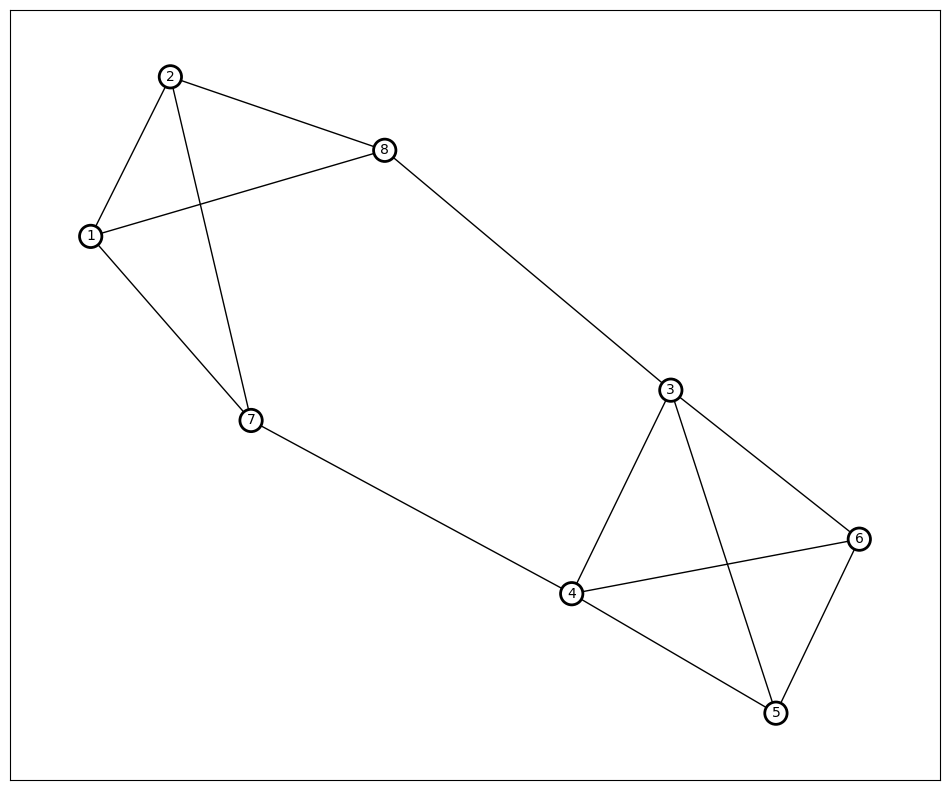

Result via 'greedy_try_all_vertices':


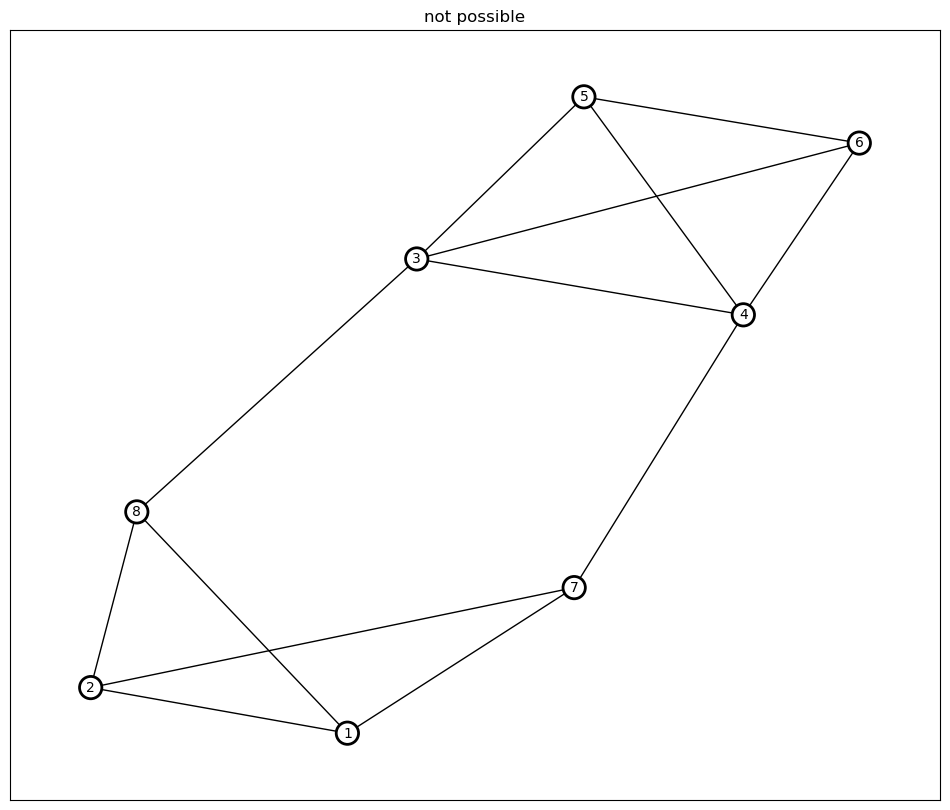

Result via 'backtracking':


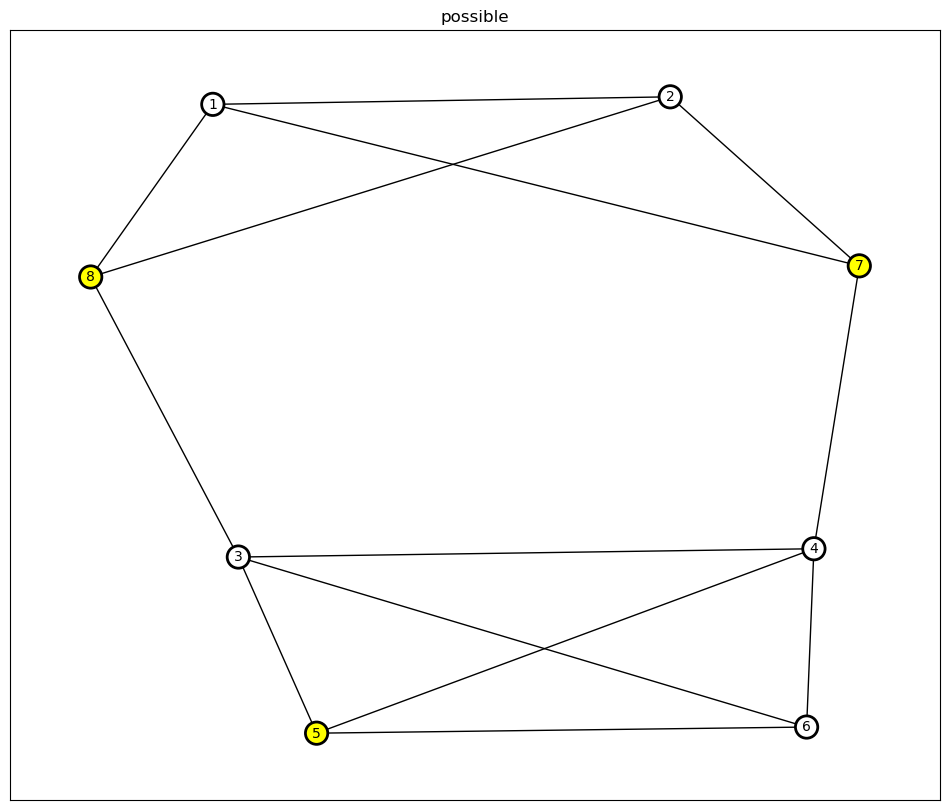

In [21]:
graph = Graph.from_file('samples/extra_1.in')
        
print("Raw Graph:")
graph.draw_graph()
graph.validate_and_show_bins(greedy_try_all_vertices)
graph.validate_and_show_bins(backtracking)


#### Algorithm testing using given test-cases

In [22]:
test_algorithm(greedy_try_all_vertices, False)

Trying 'small_6': ✅
Trying 'small_5': ✅
Trying 'small_4': ✅
Trying 'small_3': ✅
Trying 'small_2': ✅
Trying 'small_1': ✅
Trying 'extra_8': ✅
Trying 'extra_7': ✅
Trying 'extra_6': ✅
Trying 'extra_5': ✅
Trying 'extra_4': ✅
Trying 'extra_3': ❌
Trying 'extra_2': ❌
Trying 'extra_1': ❌
Trying 'big_6': ✅
Trying 'big_5': ✅
Trying 'big_4': ✅
Trying 'big_3': ✅
Trying 'big_2': ✅
Trying 'big_1': ✅
'greedy_try_all_vertices': passed 17 of 20 test cases!


In [23]:
test_algorithm(greedy_heap, False)

Trying 'small_6': ✅
Trying 'small_5': ✅
Trying 'small_4': ✅
Trying 'small_3': ✅
Trying 'small_2': ✅
Trying 'small_1': ✅
Trying 'extra_8': ✅
Trying 'extra_7': ❌
Trying 'extra_6': ✅
Trying 'extra_5': ❌
Trying 'extra_4': ❌
Trying 'extra_3': ❌
Trying 'extra_2': ❌
Trying 'extra_1': ❌
Trying 'big_6': ✅
Trying 'big_5': ✅
Trying 'big_4': ✅
Trying 'big_3': ✅
Trying 'big_2': ✅
Trying 'big_1': ✅
'greedy_heap': passed 14 of 20 test cases!


In [24]:
test_algorithm(backtracking_prune_priority, True)

Trying 'small_6': ✅
Trying 'small_5': ✅
Trying 'small_4': ✅
Trying 'small_3': ✅
Trying 'small_2': ✅
Trying 'small_1': ✅
Trying 'extra_8': ✅
Trying 'extra_7': ✅
Trying 'extra_6': ✅
Trying 'extra_5': ✅
Trying 'extra_4': ✅
Trying 'extra_3': ✅
Trying 'extra_2': ✅
Trying 'extra_1': ✅
Trying 'big_5': ✅
Trying 'big_3': ✅
Trying 'big_2': ✅
Trying 'big_1': ✅
'backtracking_prune_priority': passed 18 of 18 test cases!


In [25]:
test_algorithm(brute_force, True)

Trying 'small_6': ✅
Trying 'small_5': ✅
Trying 'small_4': ✅
Trying 'small_3': ✅
Trying 'small_2': ✅
Trying 'small_1': ✅
Trying 'extra_8': ✅
Trying 'extra_7': ✅
Trying 'extra_6': ✅
Trying 'extra_5': ✅
Trying 'extra_4': ✅
Trying 'extra_3': ✅
Trying 'extra_2':

KeyboardInterrupt: 

In [ ]:

# directory = 'samples/'
# file_paths = [(os.path.join(directory, filename))
#                for filename in os.listdir(directory)
#                if filename.endswith(".in")]

# res = {}
# for file_path in file_paths:
#     with open(file_path, 'r') as f:
#         # extract graph parameters
#         m, n, k = map(int, f.readline().split())
#         res[file_path] = (m, n, (2*m/float(n * (n-1))))

# for sample in res.keys():
#     result = res[sample]
#     print(f"{sample} | edges: {result[0]} | vercies: {result[1]} | graoh desnity: {result[2]}")

# sum1, sum2, sum3 = 0, 0, 0

# # iterate over all values in res
# for value in res.values():
#     # add each index of the tuple to the respective sum
#     sum1 += value[0]
#     sum2 += value[1]
#     sum3 += value[2]

# # compute the average for each index
# average1 = sum1 / len(res)
# average2 = sum2 / len(res)
# average3 = sum3 / len(res)

# # the averages
# print('Average of edge count:', average1)
# print('Average of vertex count:', average2)
# print('Average of edge density:', average3)

samples/big_1.in | edges: 90 | vercies: 45 | edge desnity: 0.09090909090909091
samples/big_2.in | edges: 90 | vercies: 45 | edge desnity: 0.09090909090909091
samples/big_3.in | edges: 125 | vercies: 72 | edge desnity: 0.04890453834115806
samples/big_4.in | edges: 125 | vercies: 72 | edge desnity: 0.04890453834115806
samples/big_5.in | edges: 180 | vercies: 90 | edge desnity: 0.0449438202247191
samples/big_6.in | edges: 180 | vercies: 90 | edge desnity: 0.0449438202247191
samples/extra_1.in | edges: 13 | vercies: 8 | edge desnity: 0.4642857142857143
samples/extra_2.in | edges: 77 | vercies: 39 | edge desnity: 0.1039136302294197
samples/extra_3.in | edges: 36 | vercies: 18 | edge desnity: 0.23529411764705882
samples/extra_4.in | edges: 9 | vercies: 6 | edge desnity: 0.6
samples/extra_5.in | edges: 30 | vercies: 19 | edge desnity: 0.17543859649122806
samples/extra_6.in | edges: 30 | vercies: 19 | edge desnity: 0.17543859649122806
samples/extra_7.in | edges: 22 | vercies: 13 | edge desnity